In [109]:
%matplotlib inline
import networkx as nx
import numpy as np 
import pandas as pd 
import itertools


In [110]:
import numpy as np
import networkx as nx
from networkx.algorithms import community #use community algorithm to detec communities within a graph



FielName="email-Eu-core-temporal.txt"
Graphtype=nx.DiGraph()   # use net.Graph() for undirected graph

# How to read from a file. Note: if your egde weights are int, change float to int.
G = nx.read_edgelist(FielName, create_using=Graphtype, nodetype=int, data=(('weight',float),))

get_nodes = False
if get_nodes == True:
    # Find the total number of degree, in_degree and out_degree for each node
    for x in G.nodes():
          #print ("Node: ", x, " has total #degree: ",G.degree(x), " , In_degree: ", G.out_degree(x)," and out_degree: ", G.in_degree(x))
        print(1)
get_edges = False
if get_edges == True:
    # Find the weight for each node
    for u,v in G.edges():
        #print ("Weight of Edge ("+str(u)+","+str(v)+")", G.get_edge_data(u,v))
        print(1)



# print(sorted(nx.get_edge_attributes(G, 'weight')))

In [111]:
#Plot graph 
#
#import matplotlib.pyplot as plt
#G_sub_undirected = train_test_split(df, 0.75)
#nx.draw(G_sub_undirected[0])
#plt.draw()
#plt.show()

In [112]:
#read as pandas df
df = pd.read_csv(FielName, sep = " ", header = None)
df.columns = ["start_node", "end_node", "time_stamp"]

In [113]:
#remove edges with timestamp larger than average over all timestamp 
#use the subset after removing edges as the training data to predict links 
#compare the prediction result to the edges of full dataset. 
#mean = df["time_stamp"].mean()

def train_test_split(df, percentage_of_train):
    mean = np.percentile( df["time_stamp"], percentage_of_train)
    location = (df['time_stamp'] < mean)
    sub_df = df.loc[location]
    location_test = (df['time_stamp'] > mean)
    sub_test = df.loc[location_test]
    sub_test.drop_duplicates(subset=['start_node','end_node'], inplace = True)

    #build a subgraph from dataframe created 
    G_sub=nx.from_pandas_edgelist(sub_df, "start_node", "end_node", ['time_stamp'])

    #convert to undirected for link prediction
    G_sub_undirected = G_sub.to_undirected()
    
    return [G_sub_undirected, sub_test]


In [114]:
def link_prediction(G_sub_undirected):
    #Preferential Attachment 
    preds = nx.preferential_attachment(G_sub_undirected, ebunch=None)
    PA = []
    for u, v, p in preds:
        PA.append([u,v,p])

    
    #Resource Allocation Index 
    preds_1 = nx.resource_allocation_index(G_sub_undirected, ebunch=None)
    RA = []
    for u, v, p in preds_1:
        RA.append([u,v,p])

    #Adamic-Adar Index
    preds_2 = nx.adamic_adar_index(G_sub_undirected, ebunch=None)
    AAI = []
    for u, v, p in preds_2:
        AAI.append([u,v,p])
    
    #Jaccard_coefficient
    preds_3 = nx.jaccard_coefficient(G_sub_undirected, ebunch=None)
    JC = []
    for u, v, p in preds_3:
        JC.append([u,v,p])
    #print(PA)
        
    return [PA, RA, AAI, JC]
    
#Number of Common Neighbor - removed since it require community information 
#preds_4 = nx.cn_soundarajan_hopcroft(G_sub_undirected, ebunch=None)
#CSH= []
#for u, v, p in preds_4:
   # AAI.append([u,v,p])
    
#Resource Allocation Index - removed since it require community information 
#preds_5 = nx.ra_index_soundarajan_hopcroft(G_sub_undirected, ebunch=None)
#RAI= []
#for u, v, p in preds_5:
    #RAI.append([u,v,p])
    
# Ratio of witin and inter cluster- removed since it require community information 
#preds_6 = nx.ra_index_soundarajan_hopcroft(G_sub_undirected, ebunch=None)
#WIC= []
#for u, v, p in preds_6:
   # WIC.append([u,v,p])

    



In [115]:
def evaluation(link_list, sub_test, percentile):
    i = 0
    while i < 4: 
        df_result = pd.DataFrame(link_list[i])
        df_result.columns = ['start_node', 'end_node', 'score']  
        df_result = df_result.drop(df_result[df_result.score == 0].index)
        #print(np.min(df_result["score"]))
        threshold = np.percentile( df_result["score"], percentile)
        if i == 0:
            print("Preferential Attachment:")
        if i == 1: 
            print("Resource Allocation Index: ")
        if i == 2: 
            print("Adamic-adar Index: ")
        if i == 3: 
            print("Jaccard_coefficient: ")
       
        print("Current Threshold Percentile = ", percentile)
        print("Current Threshold Value = ", threshold)
        link_location = (df_result['score'] > threshold)
        df_link = df_result.loc[link_location]
        number_edge_in_test = sub_test.shape[0]
        number_edge_in_prediction = df_link.shape[0]
        df_merged = pd.merge(df_link, sub_test , how='inner', on=['start_node','end_node'])
        df_merged.drop_duplicates(subset=['start_node','end_node'], inplace = True)
        number_edge_in_both =df_merged.shape[0]
        if number_edge_in_prediction == 0:
            print("No links predicted")
            print("----------------------------------------------------------------------------")
            i = i + 1
        else:
            print("number_edge_in_test,number_edge_in_prediction,number_edge_in_both are: ")
            print(number_edge_in_test,number_edge_in_prediction,number_edge_in_both)
            #false positive - prediction: exist, Actual: does not exist 
            print("False Positive Rate: ", (number_edge_in_prediction - number_edge_in_both)/number_edge_in_prediction)
            #false negative - prediction: does not exist, Actual: exist 
            print("False Positive Rate: ", (number_edge_in_test - number_edge_in_both)/number_edge_in_test)
            #Accuracy - percentage of links exsit in original data and is predicted by algorithm
            print("Accuracy: ", number_edge_in_both/number_edge_in_test)
            print("----------------------------------------------------------------------------")
            i = i + 1
    


In [116]:
def evaluation_data(link_list, sub_test, percentile, k):
    PA_stat = []
    RAI_stat = []
    AAI_stat = []
    JC_stat = []
    i = 0
    tracker = 0
    split = 5
    while i < 5: 
        df_result = pd.DataFrame(link_list[i-1])
        df_result.columns = ['start_node', 'end_node', 'score']  
        df_result = df_result.drop(df_result[df_result.score == 0].index)
        #print(np.min(df_result["score"]))
        threshold = np.percentile( df_result["score"], percentile)
        link_location = (df_result['score'] > threshold)
        df_link = df_result.loc[link_location]
        number_edge_in_test = sub_test.shape[0]
        number_edge_in_prediction = df_link.shape[0]
        df_merged = pd.merge(df_link, sub_test , how='inner', on=['start_node','end_node'])
        df_merged.drop_duplicates(subset=['start_node','end_node'], inplace = True)
        number_edge_in_both =df_merged.shape[0]
        if number_edge_in_prediction == 0:
            print("No links predicted")
            print("----------------------------------------------------------------------------")
            i = i + 1
        else:
            i = i + 1
            if i == 1:
                PA_stat.append([i, k*0.1, percentile,number_edge_in_both/number_edge_in_test, number_edge_in_both/number_edge_in_prediction])
            if i == 2: 
                RAI_stat.append([i, k*0.1, percentile,number_edge_in_both/number_edge_in_test, number_edge_in_both/number_edge_in_prediction])
            if i == 3: 
                AAI_stat.append([i, k*0.1, percentile,number_edge_in_both/number_edge_in_test, number_edge_in_both/number_edge_in_prediction])
            if i == 4 : 
                JC_stat.append([i, k*0.1, percentile,number_edge_in_both/number_edge_in_test, number_edge_in_both/number_edge_in_prediction])

    
    return PA_stat, RAI_stat, AAI_stat, JC_stat

In [117]:
result_data = []
for x in range (5, 9):
    print("current training size is: ", x*10)
    DF = train_test_split(df, x*0.1)
    result = link_prediction(DF[0])
    for y in range (0, 9):
        result_data.append(evaluation_data(result, DF[1], y*10, x))

    



current training size is:  50


C:\Users\eveli\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


current training size is:  60
current training size is:  70
current training size is:  80


In [139]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
PA = []
for i in range (0,36):
    PA.append(result_data[i][0][0])
headers = ["0","Training", "Threshold","Accuracy", "Positive Rate"]
PA = pd.DataFrame(PA, columns = headers)
PA.drop(['0'], axis = 1)


,Training,Threshold,Accuracy,Positive Rate
0,0.5,0,0.071466,0.360812
1,0.5,10,0.064307,0.361111
2,0.5,20,0.056183,0.358481
3,0.5,30,0.048703,0.361385
4,0.5,40,0.040700,0.367332
5,0.5,50,0.034748,0.368443
6,0.5,60,0.028353,0.378422
7,0.5,70,0.021597,0.394563
8,0.5,80,0.012186,0.385006
9,0.6,0,0.078812,0.344840


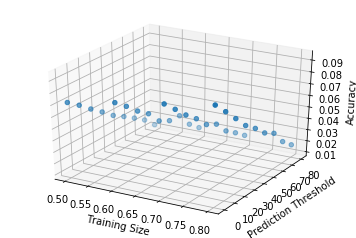

<Figure size 432x288 with 0 Axes>

In [141]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(PA['Training'], PA['Threshold'], PA['Accuracy'])
threedee.set_xlabel('Training Size')
threedee.set_ylabel('Prediction Threshold')
threedee.set_zlabel('Accuracy')
plt.show()
plt.savefig('temp.PNG', figsize=(100,80))